# Objective:
Extract data portions to improve the accuracy of a CNN model for human activity recognition using sensor data.

# Assumption/Challenges:
Presence of potential outliers in the dataset.

# Method: Moving Average over a sliding window


# Import Libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import os

from IPython.display import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.metrics import roc_curve, auc, precision_score, recall_score

import sys
sys.path.append('/content/drive/My Drive/Fortifyedge/scripts')

from helper_functions import create_windows, create_model, train_model, plot_history, eval_model, plot_cm, perf_metric, transform_data, optimized_train_eval_model,pred,perf,plot_roc_multimodel,plot_cms


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Load your sensor data into a DataFrame
data_PATH = '/content/drive/MyDrive/Fortifyedge/data/'
data = pd.read_csv(data_PATH + 'clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1412865 entries, 0 to 1412864
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   rotationRate.x      1412865 non-null  float64
 1   rotationRate.y      1412865 non-null  float64
 2   rotationRate.z      1412865 non-null  float64
 3   userAcceleration.x  1412865 non-null  float64
 4   userAcceleration.y  1412865 non-null  float64
 5   userAcceleration.z  1412865 non-null  float64
 6   act                 1412865 non-null  float64
 7   id                  1412865 non-null  float64
dtypes: float64(8)
memory usage: 86.2 MB


Changing 'act' and 'id' column to categorical values

In [4]:
data['act'] = pd.Categorical(data.act)
data['id'] = pd.Categorical(data.id)

ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]

# Define the mapping of numeric values to their corresponding string labels
act_mapping = {float(i): label for i, label in enumerate(ACT_LABELS)}

# Replace the numeric values with string labels
data['act'] = data['act'].replace(act_mapping)


In [8]:
data.head()


,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id
0,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,dws,0.0
1,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,dws,0.0
2,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,dws,0.0
3,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,dws,0.0
4,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,dws,0.0


Visualising data (1000 rows from each activity) using a continous time axis and consistent scale.

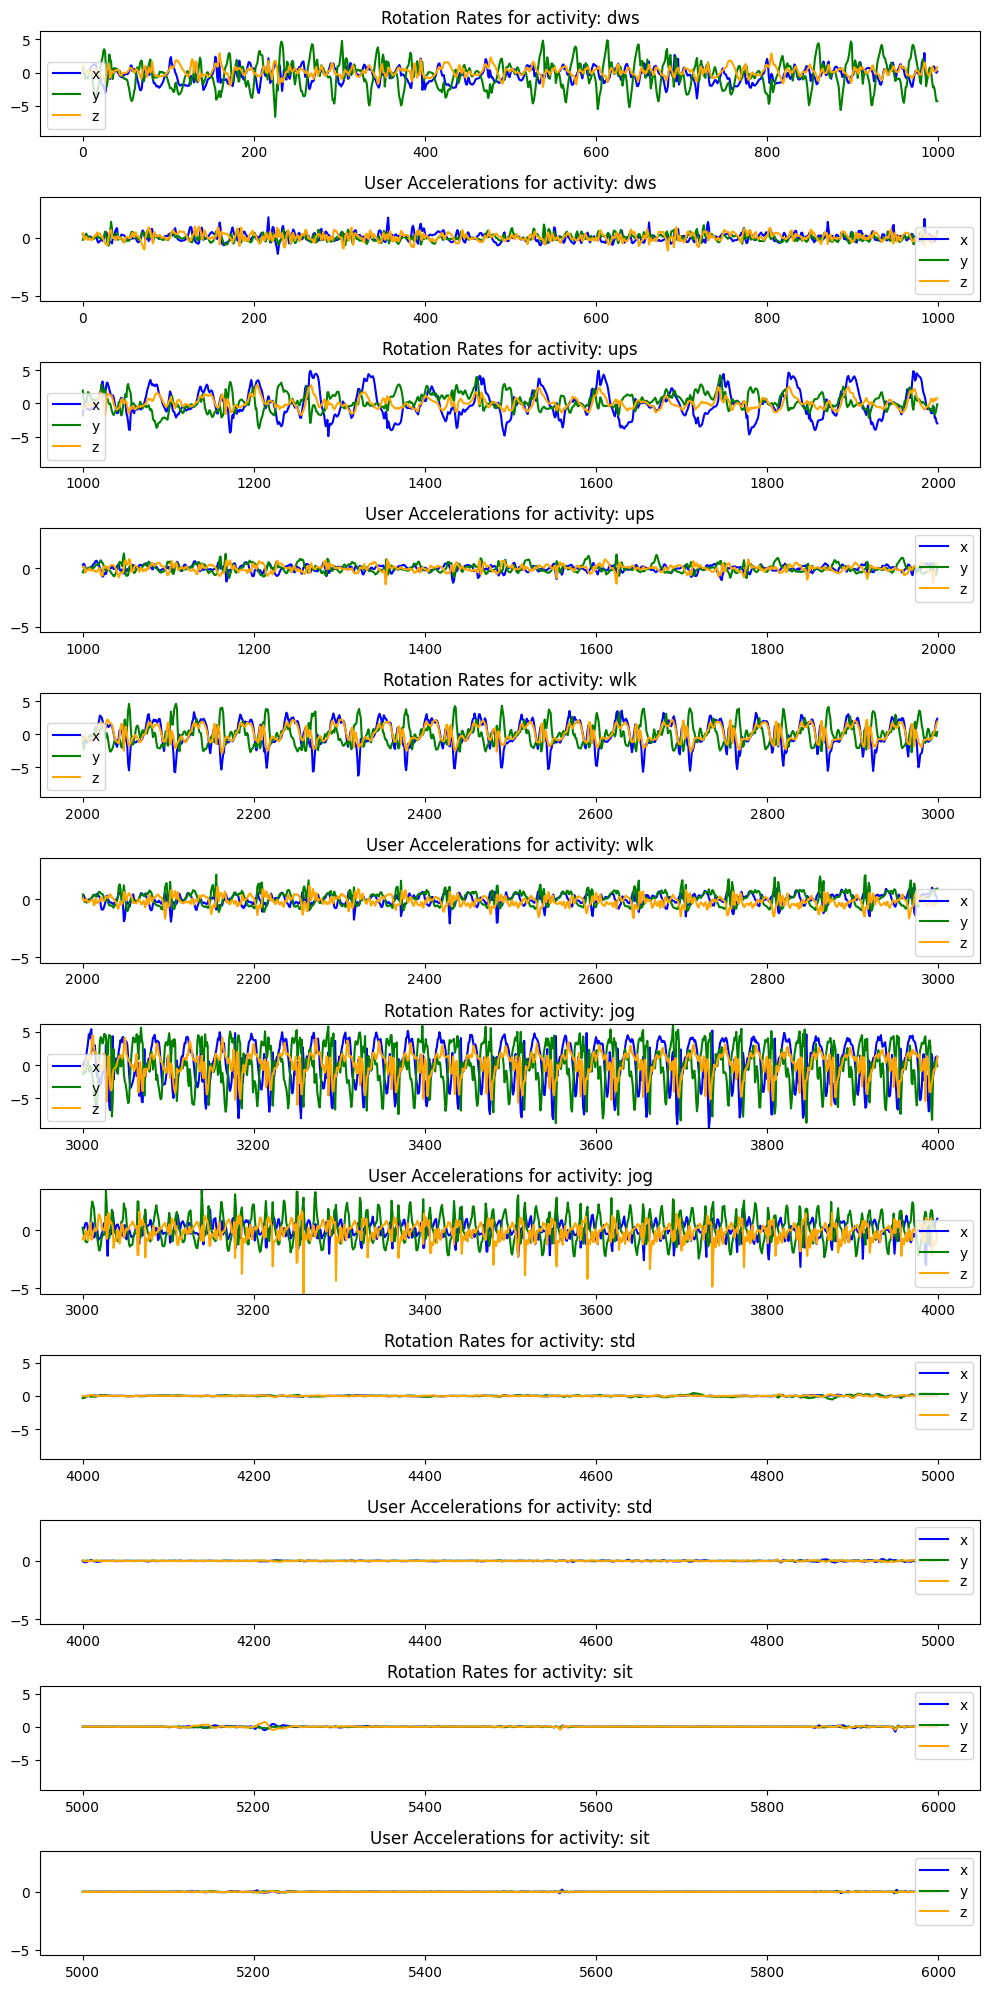

In [9]:
plt.style.use('default')

num_points = 1000  # number of points per activity
sampled_df = pd.concat([data[data['act'] == act].head(num_points) for act in ACT_LABELS])

# Create a continuous time axis
sampled_df['sequential_time'] = np.arange(len(sampled_df))

fig, axes = plt.subplots(nrows=2*len(ACT_LABELS), ncols=1, figsize=(10, 20))

# Get global min and max for user accelerations and rotation rates for consistent y-axes
global_min_acc = min(sampled_df[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']].min())
global_max_acc = max(sampled_df[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']].max())

global_min_rot = min(sampled_df[['rotationRate.x', 'rotationRate.y', 'rotationRate.z']].min())
global_max_rot = max(sampled_df[['rotationRate.x', 'rotationRate.y', 'rotationRate.z']].max())

colors = {
    "x": "blue",
    "y": "green",
    "z": "orange"
}

for i, act in enumerate(ACT_LABELS):
    act_data = sampled_df[sampled_df['act'] == act]

    ax1 = axes[2*i]
    ax1.plot(act_data['sequential_time'], act_data['rotationRate.x'], label='x', color=colors['x'])
    ax1.plot(act_data['sequential_time'], act_data['rotationRate.y'], label='y', color=colors['y'])
    ax1.plot(act_data['sequential_time'], act_data['rotationRate.z'], label='z', color=colors['z'])
    ax1.set_title(f'Rotation Rates for activity: {act}', fontsize=12)

    ax1.set_ylim(global_min_rot, global_max_rot)
    ax1.legend()

    ax2 = axes[2*i + 1]
    ax2.plot(act_data['sequential_time'], act_data['userAcceleration.x'], label='x', color=colors['x'])
    ax2.plot(act_data['sequential_time'], act_data['userAcceleration.y'], label='y', color=colors['y'])
    ax2.plot(act_data['sequential_time'], act_data['userAcceleration.z'], label='z', color=colors['z'])
    ax2.set_title(f'User Accelerations for activity: {act}', fontsize=12)

    ax2.set_ylim(global_min_acc, global_max_acc)
    ax2.legend()

plt.tight_layout()
plt.show()



The graph vividly captures the rotation rates and user accelerations for various activities, showcasing distinct patterns for each. Activities like "jogging" exhibit pronounced fluctuations, indicative of the dynamic nature of the activity, whereas "sitting" and "standing" present a more subdued and constant pattern.

The inherent fluctuations, especially in dynamic activities, can mask subtle but significant deviations from the norm. To address this challenge, we turn to the moving average method.


The moving average over a sliding window is a common technique used in time series analysis. In this method, a window of a fixed size slides over the data, one data point at a time. For each position of the window, an average of the data points within the window is calculated. This results in a smoothed version of the original series, which can highlight underlying trends and patterns in the data. By comparing the original data points to the moving average, sudden spikes or drops, which deviate significantly from the average, can be identified as potential outliers.

Applying the moving average method to each feature and visualize it to understand the effect of the window size.

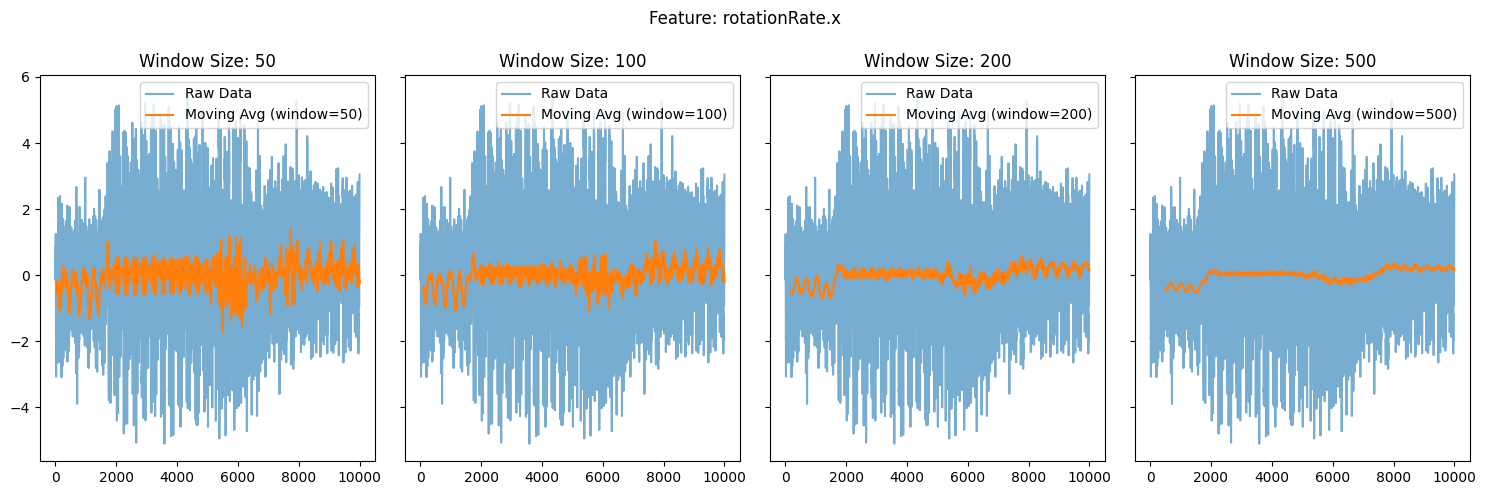

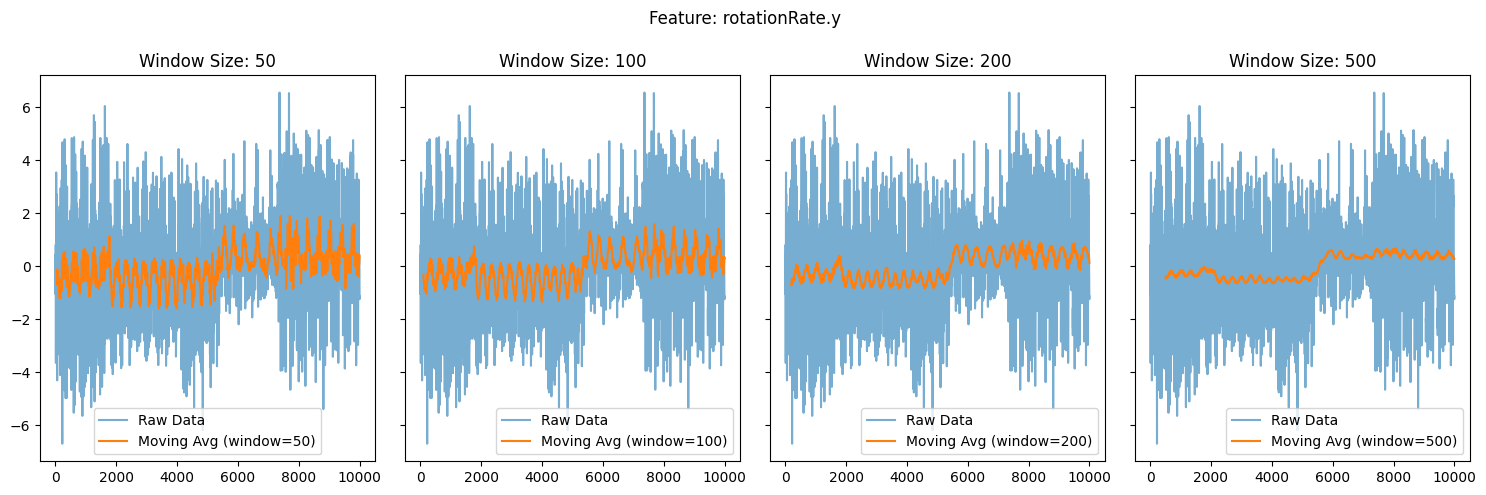

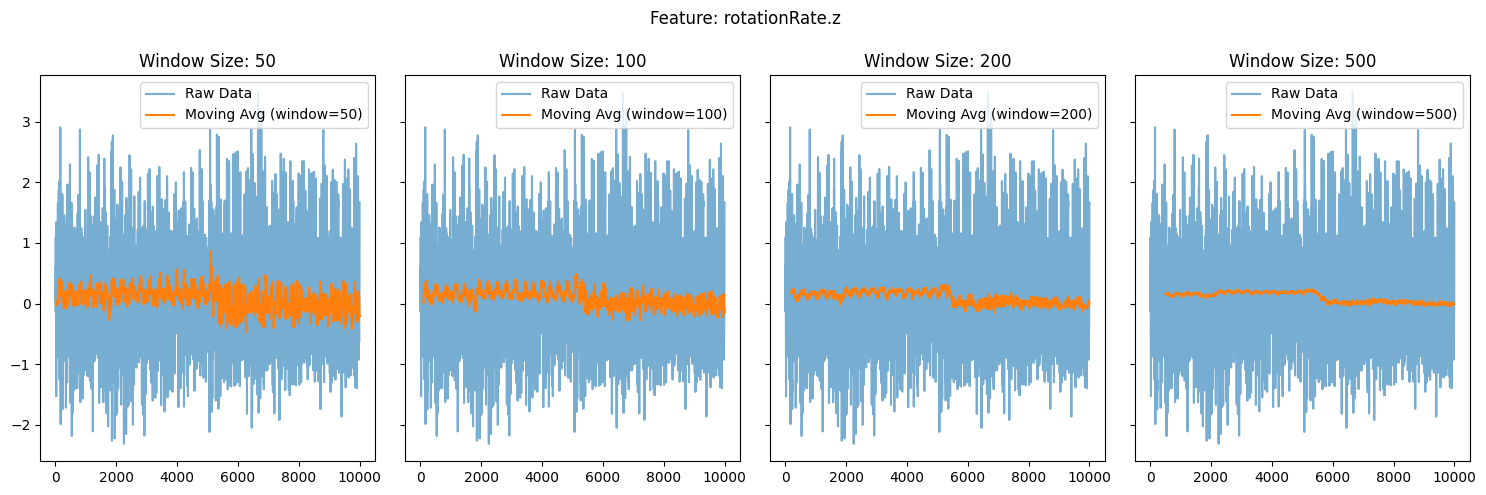

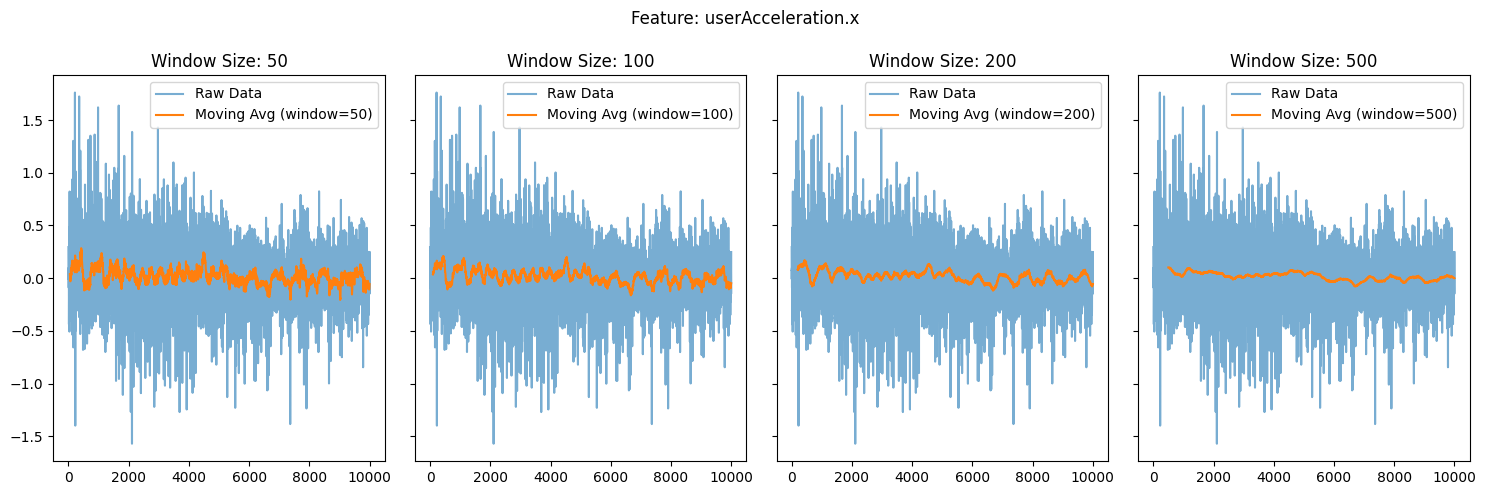

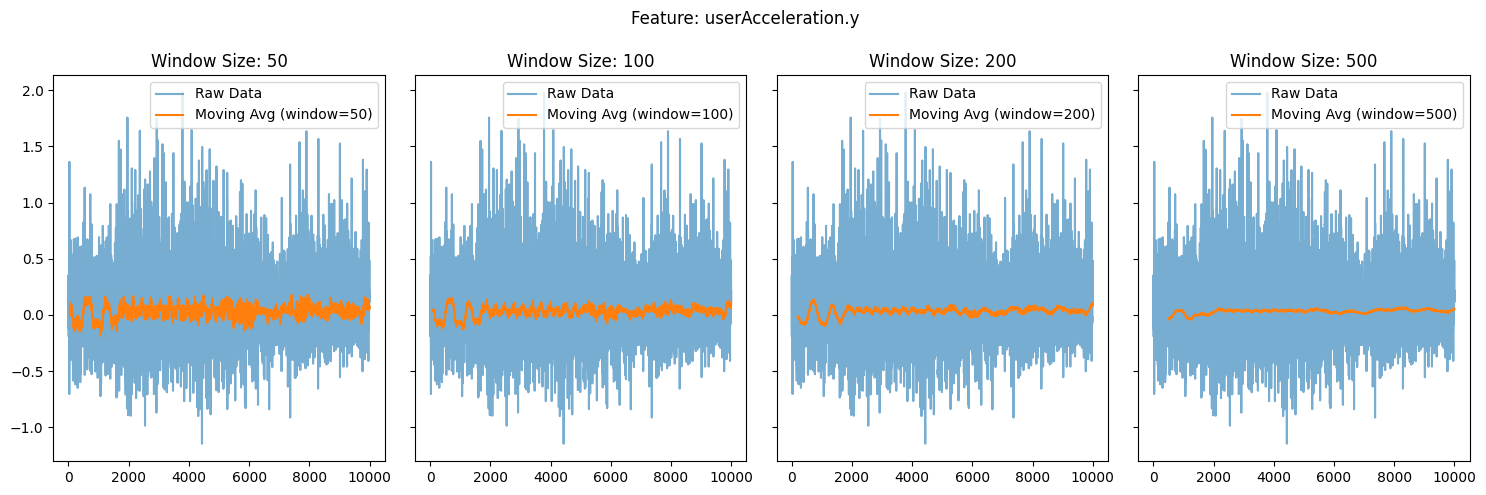

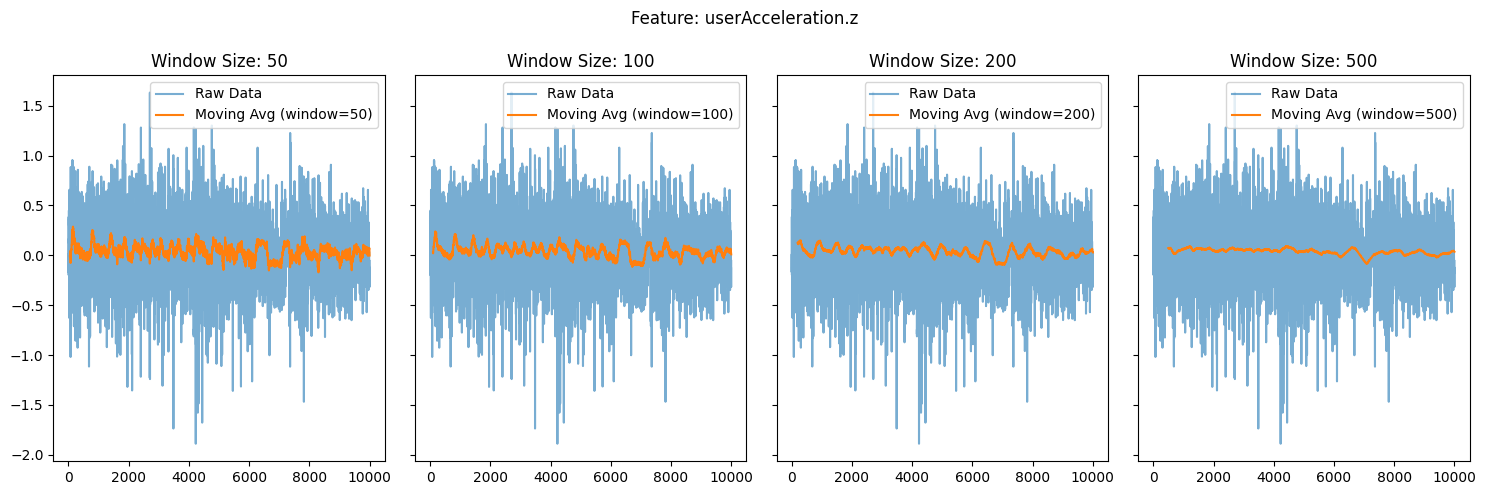

In [11]:
def plot_moving_average(data, feature, window_sizes, subset_size=10000):
    subset = data.iloc[:subset_size].copy()
    fig, axes = plt.subplots(nrows=1, ncols=len(window_sizes), figsize=(15, 5), sharey=True)

    for ax, window in zip(axes, window_sizes):
        subset['moving_avg'] = subset[feature].rolling(window=window).mean()
        ax.plot(subset[feature], label='Raw Data', alpha=0.6)
        ax.plot(subset['moving_avg'], label=f'Moving Avg (window={window})')
        ax.legend()
        ax.set_title(f"Window Size: {window}")

    fig.suptitle(f"Feature: {feature}")
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

features_to_analyze = ['rotationRate.x', 'rotationRate.y', 'rotationRate.z',
                       'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
window_sizes = [50, 100, 200, 500]  # Adjust as needed

for feature in features_to_analyze:
    plot_moving_average(data, feature, window_sizes)



Based on the visualizations above,  window size of 100 or 200 seems to strike a good balance between sensitivity to short-term fluctuations and the ability to identify longer-term deviations. However, a quantitative evaluation will be applied to identify best window-sized datasets.

In [5]:
def detect_outliers_using_moving_avg(data, features, window_size, threshold):
    """
    Detect outliers in a DataFrame using moving average across multiple features.

    Parameters:
    - data: DataFrame containing the data
    - features: List of columns (features) to analyze
    - window_size: Size of the moving average window
    - threshold: Multiplier for standard deviation to determine bounds

    Returns:
    - DataFrame with a single column "is_outlier_ma" indicating if a row is an outlier.
    """

    # Create a placeholder column for outliers, initially setting everything to False (not an outlier)
    data["is_outlier_ma"] = False

    for feature in features:
        moving_avg = data[feature].rolling(window=window_size).mean()
        moving_std = data[feature].rolling(window=window_size).std()

        upper_bound = moving_avg + threshold * moving_std
        lower_bound = moving_avg - threshold * moving_std

        is_outlier = (data[feature] > upper_bound) | (data[feature] < lower_bound)

        # Update the outlier placeholder column with OR operation to keep track of outliers from any feature
        data["is_outlier_ma"] = data["is_outlier_ma"] | is_outlier

    return data


In [6]:
# List of sensor features
sensor_features = ['rotationRate.x', 'rotationRate.y', 'rotationRate.z',
                   'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

# Detect outliers for the sensor features using moving average
data = detect_outliers_using_moving_avg(data, sensor_features, window_size=200, threshold=3)


# Print the number of outliers detected
print("Number of Outliers Detected:", data["is_outlier_ma"].sum())

Number of Outliers Detected: 94680


Visualising the data with outliers detected using the moving average method with window size of 200 and threshold 3

<ipython-input-14-139378fcb0d8>:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


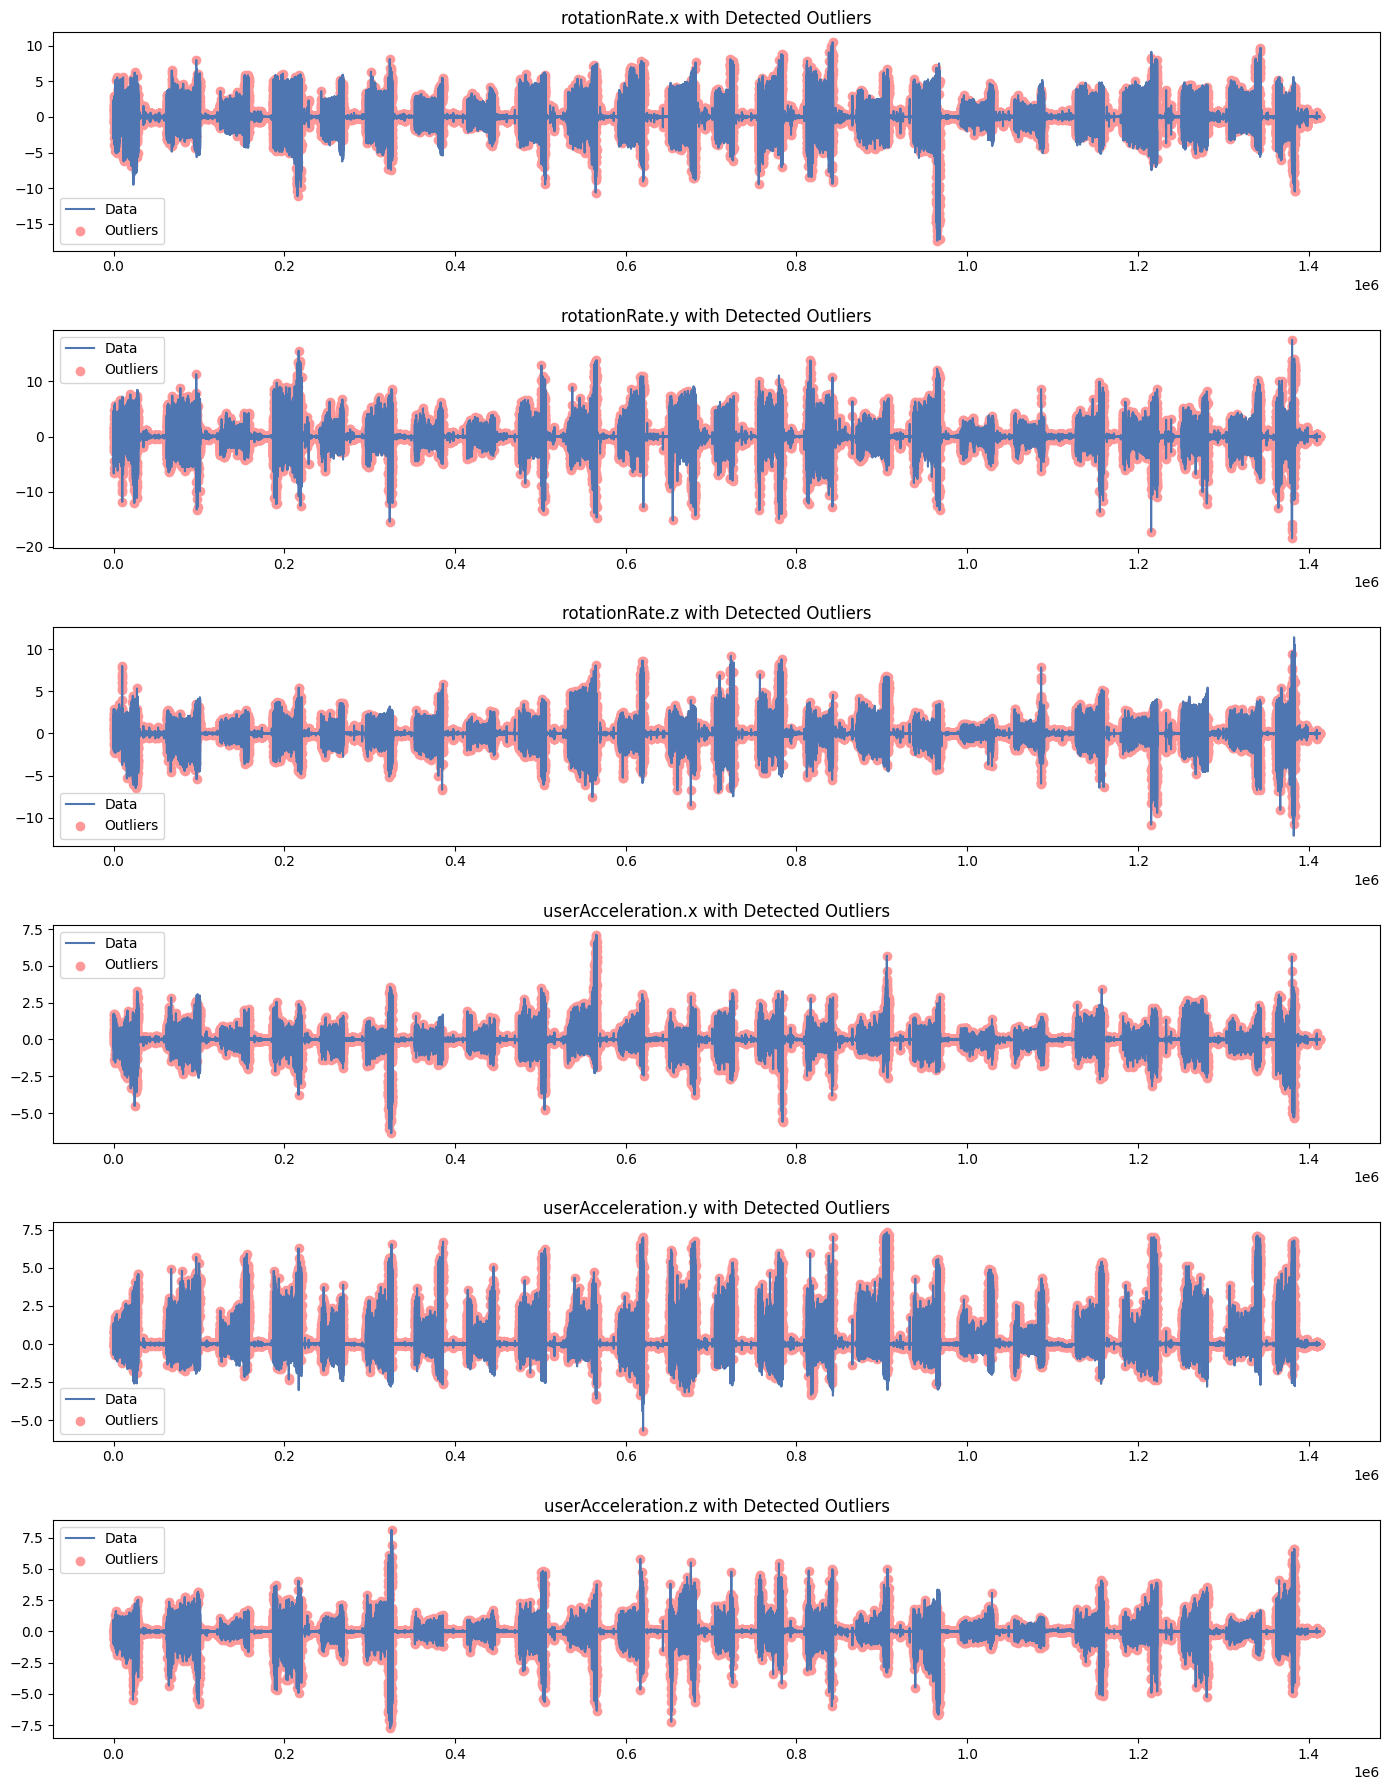

In [14]:
# Set up subplots
fig, axs = plt.subplots(len(sensor_features), 1, figsize=(14, 3 * len(sensor_features)))

# Use lighter colors
data_color = '#5076b2'  # Light blue
outlier_color = '#ff9999'  # Light red

for idx, feature in enumerate(sensor_features):
    # Plotting the feature data
    axs[idx].plot(data[feature], label='Data', color=data_color)

    # Highlighting the outliers in red
    axs[idx].scatter(data[data['is_outlier_ma']].index,
                     data[data['is_outlier_ma']][feature],
                     color=outlier_color,
                     label='Outliers')

    axs[idx].set_title(f'{feature} with Detected Outliers')
    axs[idx].legend()

# Adjust spacing between plots
plt.tight_layout()
plt.show()



From above graph, we can see that the red points have been identified as outliers.

*   The distribution of rotationRate in x,y and z axes are quite scattered throughout the timeline.

*   userAcceleration.y: Outliers are more densely packed, especially toward the latter half.


*   Magnitude of Outliers: While the rotation rates have outliers on both positive and negative extremes, the userAcceleration readings (especially y and z) seem to have outliers primarily on the positive side.

At this stage, domain expertise would be good to determine if these data points are actually outliers but we move forward with the assumption that they are and we will train the CNN model without the outliers and compare the performance.






In [42]:
outliers_df = data[data["is_outlier_ma"]]
# Save the outliers
outliers_df.to_csv('/content/drive/MyDrive/Fortifyedge/data/MovingAvg/outliers_only_200.csv', index=False)

In [ ]:
# Filter inliers and save them to a CSV file
inliers_data = data[~data["is_outlier_ma"]].drop(columns=["is_outlier_ma"])
inliers_data.to_csv('/content/drive/MyDrive/Fortifyedge/data/MovingAvg/clean_ma_200.csv',index=False)

calculate and visualize the proportion of outliers across the 6 activities:

In [15]:
outlier_proportions = []
for activity in ACT_LABELS:
    activity_subset = data[data['act'] == activity]

    num_outliers = activity_subset[activity_subset["is_outlier_ma"]].shape[0]
    total_data_points = activity_subset.shape[0]

    outlier_proportion = (num_outliers / total_data_points) * 100
    outlier_proportions.append(outlier_proportion)

    print(f"Activity: {activity}, Proportion of Outliers: {outlier_proportion:.2f}%")


Activity: dws, Proportion of Outliers: 5.92%
Activity: ups, Proportion of Outliers: 4.20%
Activity: wlk, Proportion of Outliers: 3.20%
Activity: jog, Proportion of Outliers: 3.71%
Activity: std, Proportion of Outliers: 10.24%
Activity: sit, Proportion of Outliers: 9.71%


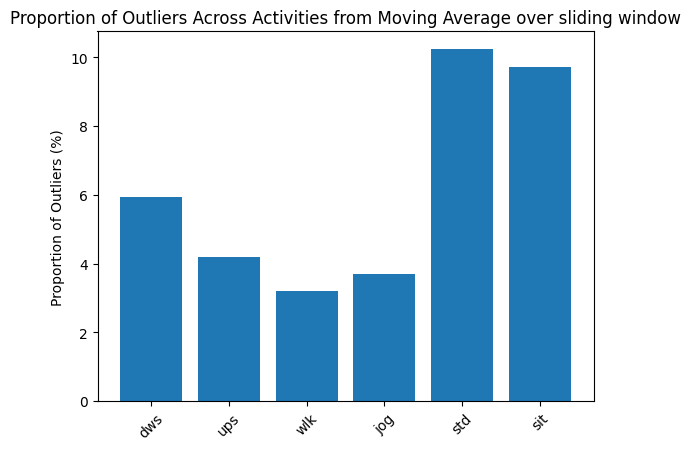

In [16]:
# Visualization
plt.bar(ACT_LABELS, outlier_proportions)
plt.ylabel('Proportion of Outliers (%)')
plt.title('Proportion of Outliers Across Activities from Moving Average over sliding window')
plt.xticks(rotation=45)
plt.show()

Standing and Sitting are the activities with highest proportion of outliers. It would be good to check the outliers with a domain expert at this stage. However, we proceed the assumption that they are indeed outliers and with the outliers removed, the remaining data is passed through the CNN model for human activity recognition. If the accuracy improves, we could possibly deem this dataset as a potential to be quality data.

Loading the csv file for the CNN model to be trained. For the convenience of the user, the trained CNN models are also provided in the folder.

In [6]:
PATH = '/content/drive/MyDrive/Fortifyedge/data/MovingAvg/'
file_path =  PATH + 'clean_ma_200.csv'
ma_data = pd.read_csv(file_path)

X,y = transform_data(ma_data)

---> Data Standardization Started
Standardization Completed in: 580.3538246154785 seconds


In [ ]:
X_train_ma, X_test_ma, y_train_ma, y_test_ma = train_test_split(X, y, test_size=0.2, random_state=None)

# Save X_test
np.save(PATH + 'X_test_mavg.npy', X_test_ma)
# Save y_test
np.save(PATH + 'y_test_mavg.npy', y_test_ma)

In [ ]:
# Save X
np.save(PATH + 'Model_data/X.npy', X)

# Save y
np.save(PATH + 'Model_data/y.npy', y)

In [7]:
model_PATH = PATH + 'Model_data/ma_model.h5'
hist_PATH = PATH + 'Model_data/ma_history.npy'
history, X_train, X_test, y_train, y_train_pred, y_train_labels, y_test, y_test_pred, y_test_labels = optimized_train_eval_model(ma_data, model_PATH, hist_PATH, X,y, epochs = 10)

--->Training Model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 47, 1, 128)        3712      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 1, 128)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 1, 128)        0         
                                                                 
 flatten (Flatten)           (None, 2944)              0         
                                                                 
 dense (Dense)               (None, 128)               376960    
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                     

In [9]:
# Function for plotting Accuracy, Loss and Learning curves
def plot_history(model_history):
    # Create a 1x2 grid of subplots
    plt.style.use("default")
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    # Plot Accuracy Curve
    axes[0].plot(model_history.history['accuracy'], 'r-', label='Training Accuracy')
    axes[0].plot(model_history.history['val_accuracy'], 'b-', label='Validation Accuracy')
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Accuracy Curve")
    axes[0].grid(True)
    axes[0].legend(loc="lower right")

    # Plot Loss Curve
    axes[1].plot(model_history.history['loss'], 'r-', label='Training Loss')
    axes[1].plot(model_history.history['val_loss'], 'b-', label='Validation Loss')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Loss Curve")
    axes[1].grid(True)
    axes[1].legend(loc="upper right")


    plt.tight_layout()
    plt.show()

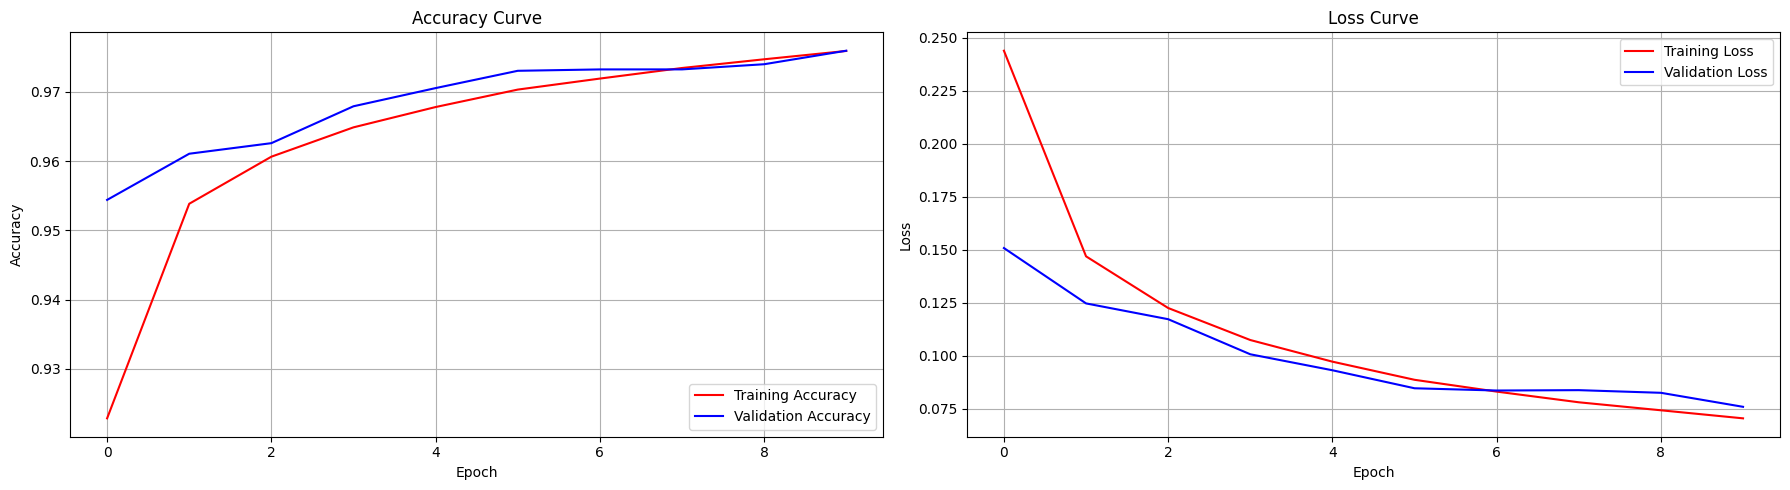

In [10]:
# Plot training & validation accuracy values
plot_history(history)

Validation Accuracy (Blue Line): The validation accuracy starts below the training accuracy but eventually catches up and closely follows the training accuracy curve. This suggests that the model is generalizing well to unseen data. There's no significant divergence between training and validation accuracy, which means there's no strong indication of overfitting.

Validation Loss (Blue Line): The validation loss decreases from an initial value, closely following the training loss. This indicates that the model is not only fitting the training data but also generalizing well to the validation data.

#Performance on moving average data portion.

In [13]:
class_report_train = classification_report(y_train_labels, y_train_pred)
print(class_report_train)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     99313
           1       0.98      0.97      0.97    120620
           2       0.99      0.99      0.99    266330
           3       1.00      0.99      0.99    103372
           4       0.99      0.98      0.99    220360
           5       0.99      0.99      0.99    244513

    accuracy                           0.99   1054508
   macro avg       0.98      0.98      0.98   1054508
weighted avg       0.99      0.99      0.99   1054508



In [14]:
class_report_test = classification_report(y_test_labels, y_test_pred)
print(class_report_test)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     24730
           1       0.97      0.96      0.97     30061
           2       0.99      0.99      0.99     66928
           3       1.00      0.99      0.99     25882
           4       0.99      0.98      0.98     54689
           5       0.98      0.99      0.99     61338

    accuracy                           0.98    263628
   macro avg       0.98      0.98      0.98    263628
weighted avg       0.98      0.98      0.98    263628



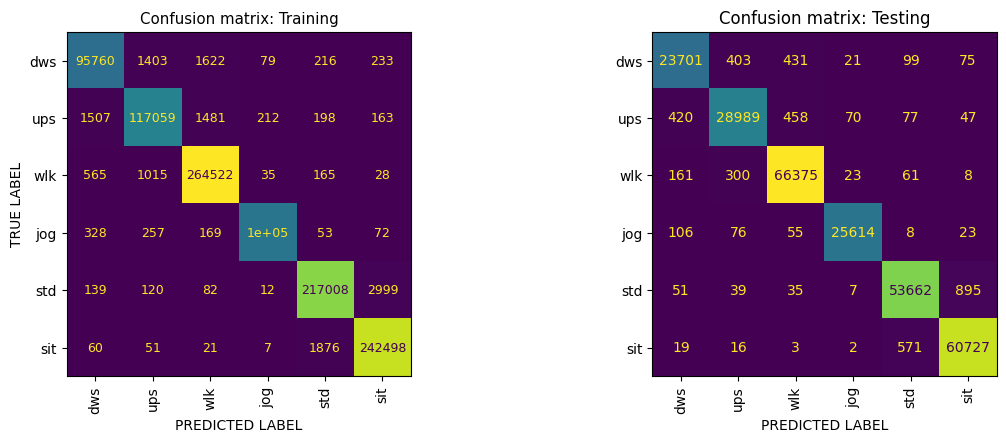

In [15]:
# Plot Confusion Matrix
plot_cm(y_train, y_train_pred, y_test, y_test_pred)

Performance comparison with base-line CNN model.

Load trained models

In [7]:
from keras.models import load_model

# Define paths for the models
base_PATH = '/content/drive/My Drive/Fortifyedge/Baseline_model/'
ma_PATH = '/content/drive/My Drive/Fortifyedge/data/MovingAvg/Model_data/'


# List of CNN models
cnn_ls = {'cnn_raw': [base_PATH, None],  # Initialize the model value as None
          'cnn_ma': [ma_PATH  + 'ma_model.h5', None]
          }

# Check if the CNN models are saved and load them
for model_name, model_info in cnn_ls.items():
    model_path = model_info[0]
    if os.path.exists(model_path):
        # Load the model
        model_info[1] = load_model(model_path)
    else:
        print(f"----> No model found for {model_name}.")

In [8]:
#ASSIGN THE CNN MODELS
cnn_baseline=cnn_ls['cnn_raw'][1]
cnn_ma=cnn_ls['cnn_ma'][1]

Load the test data

In [9]:
cnn_baseline_X_test = np.load(base_PATH + 'raw_X_test.npy')
cnn_baseline_y_test = np.load(base_PATH + 'raw_y_test.npy')
cnn_ma_X_test = np.load(ma_PATH + 'X.npy')
cnn_ma_y_test = np.load(ma_PATH +'y.npy')

Predict using the test sets

In [11]:
#predict using test sets
y_pred_raw_prob=pred(cnn_baseline,cnn_baseline_X_test)
y_pred_raw = np.argmax(y_pred_raw_prob, axis=1)

y_pred_ma_prob=pred(cnn_ma,cnn_ma_X_test)
y_pred_ma = np.argmax(y_pred_ma_prob, axis=1)

41192/41192 [==============================] - 84s 2ms/step


Load Model histories for comparison

In [20]:
baseline_history = np.load(base_PATH + 'raw_cnn_hist.npy', allow_pickle=True).item()
ma_history = np.load(ma_PATH + 'ma_history.npy', allow_pickle=True).item()

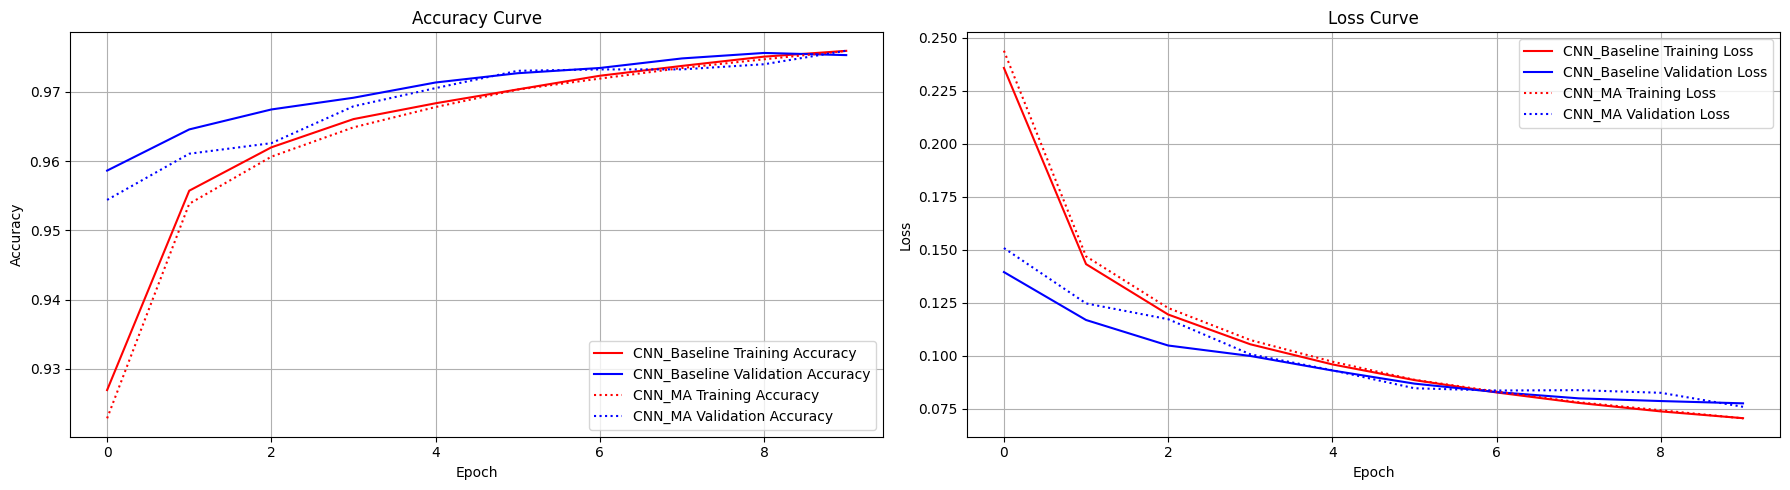

In [21]:
model_histories = [baseline_history,  ma_history]
model_labels = ["CNN_Baseline",  "CNN_MA"]
linestyles = ['-', ':']  # Choose different linestyles for the models

plot_history(model_histories, model_labels, linestyles)

Comparison of models:



*   Overfitting: The Baseline model shows signs of overfitting, as evidenced by the gap between its training and validation accuracies/losses. In contrast, the CNN_MA model seems to generalize better, with its training and validation curves being closer together.
*   Performance: Both models perform similarly by the last epoch, but the CNN_MA model appears to reach optimal performance faster, given that its curves stabilize earlier than the Baseline model.

*   Speed of Convergence: The CNN_MA model converges quicker in terms of both accuracy and loss, especially in the initial epochs, suggesting that it might be more efficient during training.


In summary, the CNN_MA model appears to be more efficient and potentially more robust than the Baseline model, given its faster convergence and better generalization as observed from the provided plots.


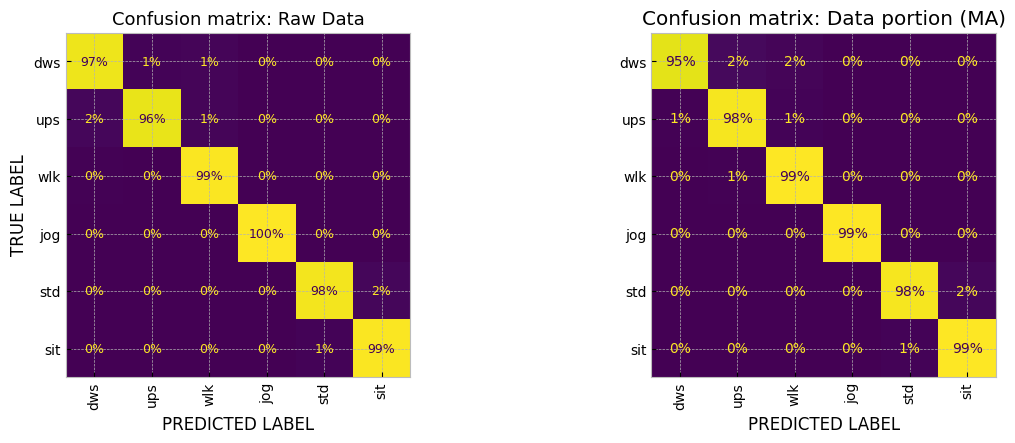

In [22]:
# PLOT CONFUSION MATRICES
plot_cms(cnn_baseline_y_test, y_pred_raw, cnn_ma_y_test, y_pred_ma)

Both models have a high overall accuracy as indicated by the dominant diagonal where true labels match predicted labels. The values on the diagonal represent correct classifications, and they are mostly close to or at 100% for both datasets.

Downstairs (dws): The model's performance is slightly better on the Raw Data (97% accuracy) compared to the Data portion (MA) which has 95% accuracy. The misclassifications for both datasets are primarily towards 'ups' and 'wlk' in the case of MA model.

Upstairs (ups): The performance is almost identical for both datasets, with 96% accuracy on Raw Data and 98% on Data portion (MA). In both cases, there are minor misclassifications towards 'dws' and 'wlk'.

There is consistent performance for the other activities in both datasets.

Both datasets yield very similar performance metrics, indicating that the preprocessing or manipulation done in the Data portion (MA) has not significantly affected the model's capability to classify the activities.

Even though the data portion derived from the moving average over sliding
window doesn't improve the accuracy, loosing almost 20% of the data has minimal adverse effects on the accuracy of the CNN model.

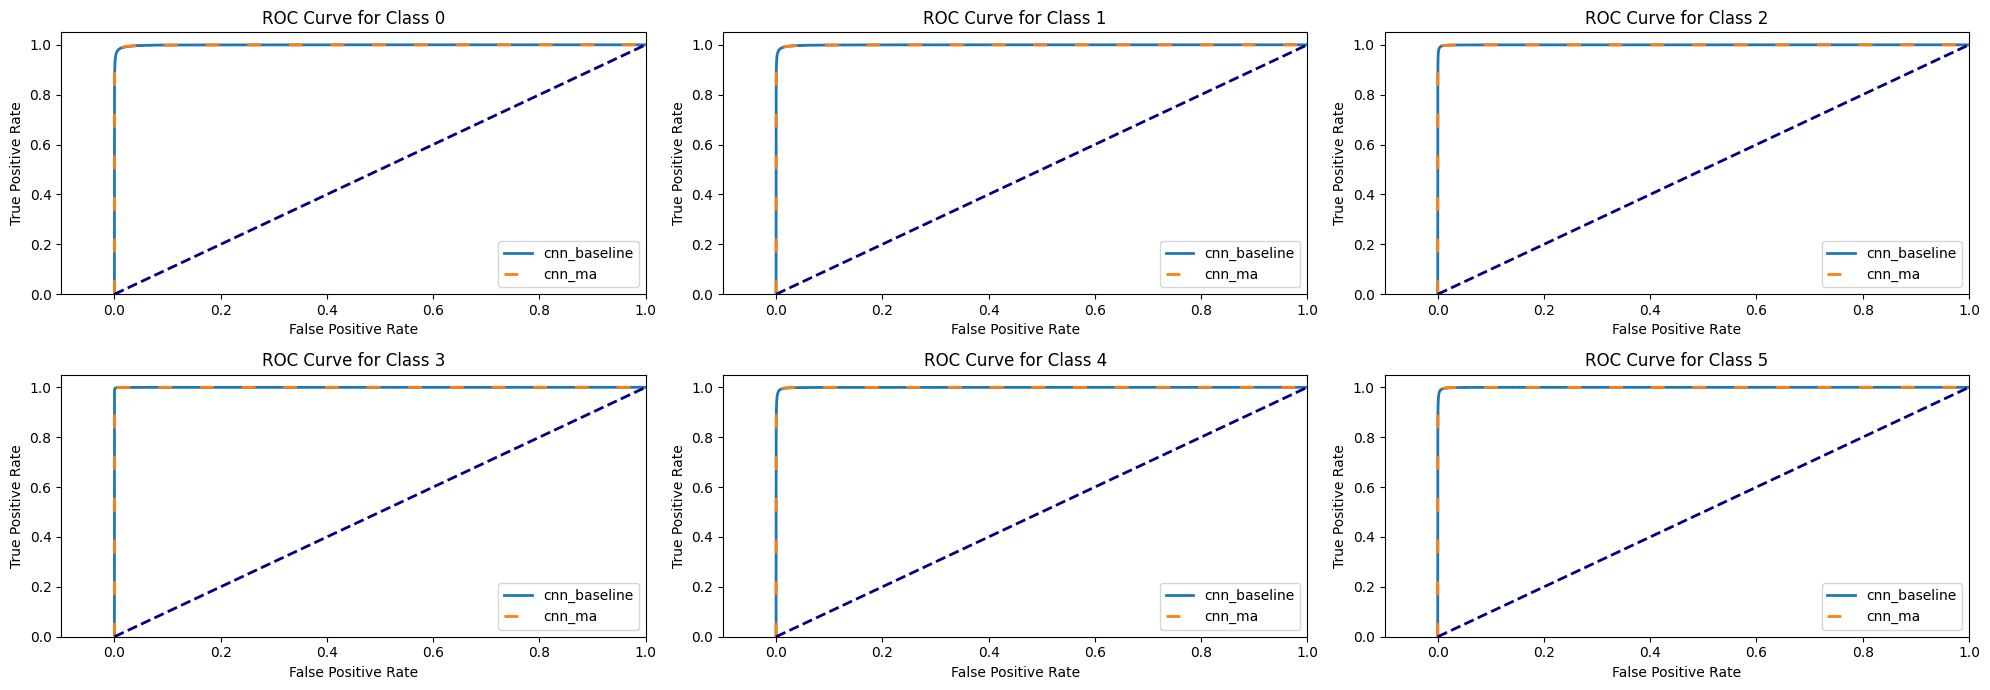

In [12]:
# from helper_functions import plot_roc_multimodel

# PLOT ROC CURVES
model_names = ['cnn_baseline', 'cnn_ma']
y_pred_prob = {
    'cnn_baseline': y_pred_raw_prob,
    'cnn_ma': y_pred_ma_prob,
}
y_set1 = cnn_baseline_y_test
y_set2 = cnn_ma_y_test
plot_roc_multimodel(y_set1, y_set2, y_pred_prob, model_names)

Both "cnn_ma" and "cnn_baseline" models exhibit near-perfect classification across all classes, with their ROC curves closely aligning.

# Conclusion

Even though the data portion derived from the moving average over sliding window doesn't improve the accuracy, it gives pretty close accuracy inspite of loosing almost 6.7% of the data. However, we should consider domain-expertise to make any further conclusions.